In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import torch.nn.functional as F

from torch import nn
from torch.utils.data import DataLoader

from torch import distributions as torchd
from torch.distributions import OneHotCategoricalStraightThrough, kl_divergence
import timeit
import numpy as np
import einops
import scipy.io

In [2]:


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [16]:
class Encoder(nn.Module):
    def __init__(self, n_input=784, n_latent=20):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(n_input,512)
        self.logits_encoder = nn.Linear(512, n_latent)

        
    def forward(self,x):
        z = torch.flatten(x, start_dim=1)
        z = F.relu(self.fc1(z))
        return self.logits_encoder(z) 
    
class Decoder(nn.Module):
    def __init__(self, n_input=784, n_latent=20):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(n_latent, 512)
        self.fc2 = nn.Linear(512, n_input)
        
    def forward(self, z):
        z = F.relu(self.fc1(z))
        z = torch.sigmoid(self.fc2(z))
        return z.reshape(-1,1,28,28)
    
class SparseBinaryVariationalAutoencoder(nn.Module):
    def __init__(self, n_input=784, shape=(8,8)):
        super(SparseBinaryVariationalAutoencoder, self).__init__()
        n_latent = shape[0] * shape[1]
        self.encoder = Encoder(n_input, n_latent)
        self.decoder = Decoder(n_input, n_latent)
        self.prior = OneHotCategoricalStraightThrough(logits=torch.zeros(shape))
        self.prior = torchd.independent.Independent(self.prior, 1)
        self.shape = shape
        
    def forward(self,x):
        logits = self.encoder(x)
        logits = logits.reshape(-1, *self.shape)
        dist = OneHotCategoricalStraightThrough(logits=logits)
        dist = torchd.independent.Independent(dist, 1)
        z = dist.rsample()
        dec_z = torch.flatten(z, start_dim=1)
        return self.decoder(dec_z), dist, z

# First experiment with (8,8) latent

In [17]:


data = torch.utils.data.DataLoader(
        datasets.MNIST('./data', 
                          transform=transforms.ToTensor(),
                          download=True,
                          train=True),
        batch_size=128,
        shuffle=True)


def vae_loss(x_recon, x, dist, z, prior, beta=1):
    
    MSE = F.mse_loss(x_recon, x, reduction='sum')
    KLD = kl_divergence(dist, prior) 
    loss = MSE + beta*KLD.sum()

    return loss



In [21]:
kl_divergence

<function torch.distributions.kl.kl_divergence(p: torch.distributions.distribution.Distribution, q: torch.distributions.distribution.Distribution) -> torch.Tensor>

In [18]:
shape = (8,8)
input_dims = 784
beta=1
epochs = 100


autoencoder = SparseBinaryVariationalAutoencoder(input_dims, shape)

print("Start training")
start_time = timeit.default_timer()
opt = torch.optim.Adam(autoencoder.parameters())
for e in range(epochs):
        epoch_loss = 0
        epoch_MSE = 0
        epoch_KLD = 0
        for x, y in data:
                x = x.to(device)
                opt.zero_grad()
                x_recon, dist, z = autoencoder(x)
#                 loss = vae_loss(x_recon, x, dist, z, autoencoder.prior, beta)
                MSE = F.mse_loss(x_recon, x, reduction='sum')
                KLD = kl_divergence(dist, autoencoder.prior).sum()
                loss = MSE + beta*KLD
                loss.backward()
                epoch_loss += loss
                epoch_MSE += MSE
                epoch_KLD += KLD
                opt.step()
        current_time = timeit.default_timer()
        print(f"Done {e}th epoch, Loss: {epoch_loss}, MSE: {epoch_MSE}, KLD: {epoch_KLD}, Time: {current_time - start_time:.0f}" )



Start training
Done 0th epoch, Loss: 3032140.0, MSE: 2864024.25, KLD: 168117.171875, Time: 3
Done 1th epoch, Loss: 2453434.75, MSE: 2137953.0, KLD: 315481.28125, Time: 7
Done 2th epoch, Loss: 2342740.25, MSE: 1986275.125, KLD: 356464.03125, Time: 10
Done 3th epoch, Loss: 2289327.5, MSE: 1914369.25, KLD: 374958.78125, Time: 14
Done 4th epoch, Loss: 2253821.5, MSE: 1869228.25, KLD: 384593.84375, Time: 17
Done 5th epoch, Loss: 2228096.0, MSE: 1836598.125, KLD: 391498.8125, Time: 20
Done 6th epoch, Loss: 2210196.0, MSE: 1813340.625, KLD: 396855.46875, Time: 24
Done 7th epoch, Loss: 2200926.25, MSE: 1799148.875, KLD: 401778.59375, Time: 27
Done 8th epoch, Loss: 2183507.0, MSE: 1779358.875, KLD: 404148.4375, Time: 31
Done 9th epoch, Loss: 2175825.5, MSE: 1767011.875, KLD: 408814.96875, Time: 34


KeyboardInterrupt: 

In [9]:
shape = (8,8)
input_dims = 784
beta=0
epochs = 100


autoencoder = SparseBinaryVariationalAutoencoder(input_dims, shape)

print("Start training")
start_time = timeit.default_timer()
opt = torch.optim.Adam(autoencoder.parameters())
for e in range(epochs):
        epoch_loss = 0
        epoch_MSE = 0
        epoch_KLD = 0
        for x, y in data:
                x = x.to(device)
                opt.zero_grad()
                x_recon, dist, z = autoencoder(x)
#                 loss = vae_loss(x_recon, x, dist, z, autoencoder.prior, beta)
                MSE = F.mse_loss(x_recon, x, reduction='sum')
                KLD = kl_divergence(dist, autoencoder.prior).sum()
                loss = MSE + beta*KLD
                loss.backward()
                epoch_loss += loss
                epoch_MSE += MSE
                epoch_KLD += KLD
                opt.step()
        current_time = timeit.default_timer()
        print(f"Done {e}th epoch, Loss: {epoch_loss}, MSE: {epoch_MSE}, KLD: {epoch_KLD}, Time: {current_time - start_time:.0f}" )



Start training
Done 0th epoch, Loss: 3217732.75, MSE: 3217732.75, KLD: 964967.25, Time: 3
Done 1th epoch, Loss: 2511630.25, MSE: 2511630.25, KLD: 907091.3125, Time: 7
Done 2th epoch, Loss: 1966223.125, MSE: 1966223.125, KLD: 838224.1875, Time: 10
Done 3th epoch, Loss: 1813389.25, MSE: 1813389.25, KLD: 825678.9375, Time: 14
Done 4th epoch, Loss: 1740101.375, MSE: 1740101.375, KLD: 823167.5, Time: 17
Done 5th epoch, Loss: 1699063.125, MSE: 1699063.125, KLD: 824271.0625, Time: 20
Done 6th epoch, Loss: 1673132.0, MSE: 1673132.0, KLD: 824062.1875, Time: 24
Done 7th epoch, Loss: 1652841.25, MSE: 1652841.25, KLD: 825239.5625, Time: 27
Done 8th epoch, Loss: 1640256.25, MSE: 1640256.25, KLD: 822757.25, Time: 31
Done 9th epoch, Loss: 1612408.375, MSE: 1612408.375, KLD: 809698.5, Time: 34
Done 10th epoch, Loss: 1586873.625, MSE: 1586873.625, KLD: 806101.4375, Time: 38
Done 11th epoch, Loss: 1570764.0, MSE: 1570764.0, KLD: 805765.5625, Time: 41
Done 12th epoch, Loss: 1558272.75, MSE: 1558272.75, K

In [20]:
dist.event_shape

torch.Size([8, 8])

In [10]:
shape = (8,8)
input_dims = 784
beta=4
epochs = 100


autoencoder = SparseBinaryVariationalAutoencoder(input_dims, shape)

print("Start training")
start_time = timeit.default_timer()
opt = torch.optim.Adam(autoencoder.parameters())
for e in range(epochs):
        epoch_loss = 0
        epoch_MSE = 0
        epoch_KLD = 0
        for x, y in data:
                x = x.to(device)
                opt.zero_grad()
                x_recon, dist, z = autoencoder(x)
#                 loss = vae_loss(x_recon, x, dist, z, autoencoder.prior, beta)
                MSE = F.mse_loss(x_recon, x, reduction='sum')
                KLD = kl_divergence(dist, autoencoder.prior).sum()
                loss = MSE + beta*KLD
                loss.backward()
                epoch_loss += loss
                epoch_MSE += MSE
                epoch_KLD += KLD
                opt.step()
        current_time = timeit.default_timer()
        print(f"Done {e}th epoch, Loss: {epoch_loss}, MSE: {epoch_MSE}, KLD: {epoch_KLD}, Time: {current_time - start_time:.0f}" )



Start training
Done 0th epoch, Loss: 3325627.25, MSE: 3277221.25, KLD: 12101.26953125, Time: 4
Done 1th epoch, Loss: 3076548.25, MSE: 2903636.25, KLD: 43228.0, Time: 7
Done 2th epoch, Loss: 3050967.0, MSE: 2818629.5, KLD: 58084.49609375, Time: 10
Done 3th epoch, Loss: 3042856.75, MSE: 2788957.25, KLD: 63474.9375, Time: 14
Done 4th epoch, Loss: 3030589.75, MSE: 2766307.5, KLD: 66069.9453125, Time: 17
Done 5th epoch, Loss: 3026577.5, MSE: 2750769.5, KLD: 68951.9765625, Time: 21
Done 6th epoch, Loss: 3022544.5, MSE: 2738443.75, KLD: 71025.46875, Time: 24
Done 7th epoch, Loss: 3021093.75, MSE: 2731502.5, KLD: 72397.4375, Time: 28
Done 8th epoch, Loss: 3017626.5, MSE: 2725256.75, KLD: 73092.40625, Time: 31
Done 9th epoch, Loss: 3013794.75, MSE: 2715284.5, KLD: 74627.6640625, Time: 35
Done 10th epoch, Loss: 3010700.75, MSE: 2706984.0, KLD: 75929.109375, Time: 38
Done 11th epoch, Loss: 3012401.25, MSE: 2706370.75, KLD: 76508.21875, Time: 42
Done 12th epoch, Loss: 3011945.5, MSE: 2701457.75, K

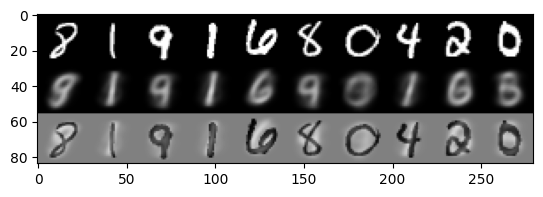

In [11]:
test_data = torch.utils.data.DataLoader(
        datasets.MNIST('./data', 
                          transform=transforms.ToTensor(),
                          download=True,
                          train=False),
        batch_size=10,
        shuffle=True)

x, y = next(iter(test_data))

with torch.no_grad():
    x_recon, dist, z = autoencoder(x.to(device))
    diff = ((x_recon - x)+1)/2.0 
    img = torch.cat([x, x_recon, diff], 2)
    img = einops.rearrange(img, 'b c h w ->  h (b w) c')
    img = img.to('cpu').detach().numpy()
    # img = (img +1) /2
plt.figure()
plt.imshow(img, 'gray'  )
plt.savefig('output/vae_sampling.png')
    
   

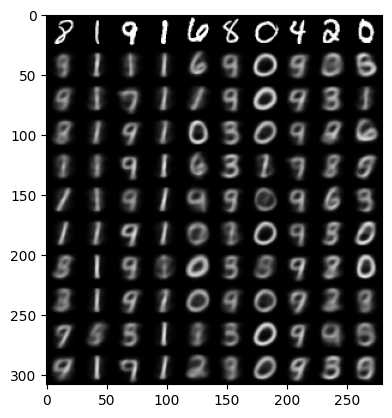

In [12]:
samples = x.clone()
samples = einops.rearrange(samples,'b c h w ->  h (b w) c')

for i in range(10):
    z = dist.sample()
    z = torch.flatten(z, start_dim=1)
    img = autoencoder.decoder(z)
    

    img = einops.rearrange(img, 'b c h w ->  h (b w) c')
    samples = torch.cat((samples, img), dim=0)
    
img = samples.to('cpu').detach().numpy()    
plt.figure()
plt.imshow(img, 'gray'  )

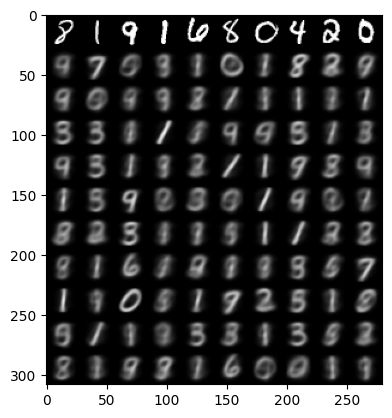

In [13]:
samples = x.clone()
samples = einops.rearrange(samples,'b c h w ->  h (b w) c')

for i in range(10):
    a = torch.zeros(10)
    z = autoencoder.prior.sample(a.size())
    # z = einops.rearrange(z, 'a b -> 1 (a b)')
    z = torch.flatten(z, start_dim=1)
    img = autoencoder.decoder(z)
    

    img = einops.rearrange(img, 'b c h w ->  h (b w) c')
    samples = torch.cat((samples, img), dim=0)
    
img = samples.to('cpu').detach().numpy()    
plt.figure()
plt.imshow(img, 'gray'  )

# Second Changing the latent and see the effects

In [ ]:
shape = (2,8)
input_dims = 784
beta=1
epochs = 100


autoencoder = SparseBinaryVariationalAutoencoder(input_dims, shape)

print("Start training")
start_time = timeit.default_timer()
opt = torch.optim.Adam(autoencoder.parameters())
for e in range(epochs):
        epoch_loss = 0
        for x, y in data:
                x = x.to(device)
                opt.zero_grad()
                x_recon, dist, z = autoencoder(x)
                loss = vae_loss(x_recon, x, dist, z, autoencoder.prior, beta)
                loss.backward()
                epoch_loss += loss
                opt.step()
        current_time = timeit.default_timer()
        print(f"Done {e}th epoch, Loss: {epoch_loss} Time: {current_time - start_time:.0f}" )



In [ ]:
test_data = torch.utils.data.DataLoader(
        datasets.MNIST('./data', 
                          transform=transforms.ToTensor(),
                          download=True,
                          train=False),
        batch_size=10,
        shuffle=True)
x, y = next(iter(test_data))

with torch.no_grad():
    x_recon, dist = autoencoder(x.to(device))
    diff = ((x_recon - x)+1)/2.0 
    img = torch.cat([x, x_recon, diff], 2)
    img = einops.rearrange(img, 'b c h w ->  h (b w) c')
    img = img.to('cpu').detach().numpy()
    # img = (img +1) /2
plt.figure()
plt.imshow(img, 'gray'  )
plt.savefig('output/vae_sampling.png')

In [ ]:
samples = x.clone()
samples = einops.rearrange(samples,'b c h w ->  h (b w) c')

for i in range(10):
    z = dist.sample()
    z = torch.flatten(z, start_dim=1)
    img = autoencoder.decoder(z)
    

    img = einops.rearrange(img, 'b c h w ->  h (b w) c')
    samples = torch.cat((samples, img), dim=0)
    
img = samples.to('cpu').detach().numpy()    
plt.figure()
plt.imshow(img, 'gray'  )

In [ ]:
samples = torch.zeros(( 28*8, 28*8))


for i in range(8):
    for j in range(8):
        z = torch.zeros((2,8))
        z[0,j] = 1
        z[1, i] = 1
        z = einops.rearrange(z, 'a b -> 1 (a b)')
        # z = torch.flatten(z, start_dim=1)
        img = autoencoder.decoder(z)
        samples[28*i:28*(i+1), 28*j:28*(j+1)] = img[0,0,:,:]


    
img = samples.to('cpu').detach().numpy()    
plt.figure()
plt.imshow(img, 'gray'  )

# 3 Experiment.  (2,4) latent

In [ ]:
# Changing the latent and see the effects
shape = (2,4)
# prior = OneHotCategoricalStraightThrough(logits=torch.zeros(shape))
# prior.sample()
input_dims = 784


autoencoder = SparseBinaryVariationalAutoencoder(input_dims, shape)

data = torch.utils.data.DataLoader(
        datasets.MNIST('./data', 
                          transform=transforms.ToTensor(),
                          download=True,
                          train=True),
        batch_size=128,
        shuffle=True)



beta=0
epochs = 100


# def vae_loss(x_recon, x, dist, prior, beta=0.001):
#     BCE = F.binary_cross_entropy(x_recon, x, reduction='sum')
# #     logits = dist.base_dist.logits.sum(dim=0)
# #     aDist = torchd.OneHotCategorical(logits=logits)
# #     aDist = torchd.independent.Independent(aDist, 1)
#     KLD = kl_divergence(dist, prior)
#     # print(BCE, KLD)
#     return BCE + beta* KLD.mean()


print("Start training")
start_time = timeit.default_timer()
opt = torch.optim.Adam(autoencoder.parameters())
for e in range(epochs):
        epoch_loss = 0
        for x, y in data:
                x = x.to(device)
                opt.zero_grad()
                x_recon, dist = autoencoder(x)
                loss = vae_loss(x_recon, x, dist, autoencoder.prior, beta)
                loss.backward()
                epoch_loss += loss
                opt.step()
        current_time = timeit.default_timer()
        print(f"Done {e}th epoch, Loss: {epoch_loss} Time: {current_time - start_time:.0f}" )



In [ ]:

test_data = torch.utils.data.DataLoader(
        datasets.MNIST('./data', 
                          transform=transforms.ToTensor(),
                          download=True,
                          train=False),
        batch_size=10,
        shuffle=True)
x, y = next(iter(test_data))

with torch.no_grad():
    x_recon, dist, z = autoencoder(x.to(device))
    diff = ((x_recon - x)+1)/2.0 
    img = torch.cat([x, x_recon, diff], 2)
    img = einops.rearrange(img, 'b c h w ->  h (b w) c')
    img = img.to('cpu').detach().numpy()
    # img = (img +1) /2
plt.figure()
plt.imshow(img, 'gray'  )
plt.savefig('output/vae_sampling.png')
samples = x.clone()
samples = einops.rearrange(samples,'b c h w ->  h (b w) c')

for i in range(10):
    z = dist.sample()
    z = torch.flatten(z, start_dim=1)
    img = autoencoder.decoder(z)
    

    img = einops.rearrange(img, 'b c h w ->  h (b w) c')
    samples = torch.cat((samples, img), dim=0)
    
img = samples.to('cpu').detach().numpy()    
plt.figure()
plt.imshow(img, 'gray'  )
samples = torch.zeros(( 28*4, 28*4))


for i in range(4):
    for j in range(4):
        z = torch.zeros((2,4))
        z[0,j] = 1
        z[1, i] = 1
        z = einops.rearrange(z, 'a b -> 1 (a b)')
        # z = torch.flatten(z, start_dim=1)
        img = autoencoder.decoder(z)
        samples[28*i:28*(i+1), 28*j:28*(j+1)] = img[0,0,:,:]


    
img = samples.to('cpu').detach().numpy()    
plt.figure()
plt.imshow(img, 'gray'  )

# 4. Face dataset

In [ ]:
class Encoder(nn.Module):
    def __init__(self, n_input=784, n_latent=20):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(n_input,512)
        self.logits_encoder = nn.Linear(512, n_latent)

        
    def forward(self,x):
        z = torch.flatten(x, start_dim=1)
        z = F.relu(self.fc1(z))
        return self.logits_encoder(z) 
    
class Decoder(nn.Module):
    def __init__(self, n_input=784, n_latent=20):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(n_latent, 512)
        self.fc2 = nn.Linear(512, n_input)
        
    def forward(self, z):
        z = F.relu(self.fc1(z))
        z = torch.sigmoid(self.fc2(z))
        return z.reshape(-1,1,28,20)
    
class SparseBinaryVariationalAutoencoder(nn.Module):
    def __init__(self, n_input=784, shape=(8,8)):
        super(SparseBinaryVariationalAutoencoder, self).__init__()
        n_latent = shape[0] * shape[1]
        self.encoder = Encoder(n_input, n_latent)
        self.decoder = Decoder(n_input, n_latent)
        self.prior = OneHotCategoricalStraightThrough(logits=torch.zeros(shape))
        self.prior = torchd.independent.Independent(self.prior,1)
        self.shape = shape
        
    def forward(self,x):
        logits = self.encoder(x)
        logits = logits.reshape(-1, *self.shape)
        dist = OneHotCategoricalStraightThrough(logits=logits)
        dist = torchd.independent.Independent(dist,1)
        z = dist.rsample()
        dec_z = torch.flatten(z, start_dim=1)
        return self.decoder(dec_z), dist, z

In [ ]:
shape = (32, 32)
# prior = OneHotCategoricalStraightThrough(logits=torch.zeros(shape))
# prior.sample()
# input_dims = 784
IMG_WIDTH = 20
IMG_HEIGHT = 28
IMG_CHANNELS = 1 
NUM_LATENT_DIM = 2
BATCH_SIZE = 128
input_dims = IMG_WIDTH * IMG_HEIGHT * IMG_CHANNELS




def train_face(autoencoder, data, epochs = 50):
    print("Start training")
    start_time = timeit.default_timer()
    opt = torch.optim.Adam(autoencoder.parameters())
    for e in range(epochs):
        epoch_loss = 0
        for x in data:
            x = x.to(device)
            opt.zero_grad()
            x_recon, dist,z  = autoencoder(x)
            loss = vae_loss(x_recon, x, dist, z, beta=0)
            loss.backward()
            epoch_loss += loss.mean()
            opt.step()
        current_time = timeit.default_timer()
        print(f"Done {e}th epoch, Loss: {epoch_loss} Time: {current_time - start_time:.0f}" )
    return autoencoder

def get_FreyFace_data():
    ff = scipy.io.loadmat('data/face/frey_rawface.mat')
    ff = ff["ff"].T.reshape((-1, IMG_CHANNELS, IMG_HEIGHT, IMG_WIDTH))
    ff = ff.astype('float32')/255.
    ff_torch = torch.from_numpy(ff)
    return ff_torch


autoencoder = SparseBinaryVariationalAutoencoder(input_dims, shape)

face = get_FreyFace_data()
face_data = torch.utils.data.DataLoader(
        face, 
        batch_size=128,
        shuffle=True)

autoencoder = train_face(autoencoder, face_data, epochs=1000)


In [ ]:

x = next(iter(face_data))

x = x[:10]

with torch.no_grad():
    x_recon, dist,z = autoencoder(x.to(device))
    diff = ((x_recon - x)+1)/2.0 
    img = torch.cat([x, x_recon, diff], 2)
    img = einops.rearrange(img, 'b c h w ->  h (b w) c')
    img = img.to('cpu').detach().numpy()
    # img = (img +1) /2
plt.figure(figsize=(100,100))
plt.imshow(img, 'gray'  )
plt.savefig('output/vae_sampling.png')
samples = x.clone()
samples = einops.rearrange(samples,'b c h w ->  h (b w) c')

for i in range(10):
    z = dist.sample()
    z = torch.flatten(z, start_dim=1)
    img = autoencoder.decoder(z)
    

    img = einops.rearrange(img, 'b c h w ->  h (b w) c')
    samples = torch.cat((samples, img), dim=0)
    
img = samples.to('cpu').detach().numpy()    
plt.figure()
plt.imshow(img, 'gray'  )
samples = torch.zeros(( 28*8, 20*8))


# for i in range(8):
#     for j in range(8):
#         z = torch.zeros((2,8))
#         z[0,j] = 1
#         z[1, i] = 1
#         z = einops.rearrange(z, 'a b -> 1 (a b)')
#         # z = torch.flatten(z, start_dim=1)
#         img = autoencoder.decoder(z)
#         samples[28*i:28*(i+1), 20*j:20*(j+1)] = img[0,0,:,:]


    
# img = samples.to('cpu').detach().numpy()    
# plt.figure()
# plt.imshow(img, 'gray'  )

In [ ]:
img.shape


In [ ]:
samples.shape

In [ ]:
enc1 = nn.Conv3d(1, 
                  2,
                  (2,4,4), (1,2,2), 
                  padding=(0,1,1)
                  )

enc2 = nn.Conv3d(2, 
                  4,
                  (2,4,4), (1,2,2), 
                  padding=(0,1,1)
                  )

dec1 = nn.ConvTranspose3d(4,
                         2,
                         (2,4,4),
                         (1, 2,2),
                         padding=(0,1,1))

dec2 = nn.ConvTranspose3d(2,
                         1,
                         (2,4,4),
                         (1, 2,2),
                         padding=(0,1,1))



In [ ]:
x = torch.rand((10,1,4,64,64))

In [ ]:
out1 = enc1(x)
print(out1.shape)
out2 = enc2(out1)
print(out2.shape)

In [ ]:
out3 = dec1(out2)
print(out3.shape)
out4 = dec2(out3)
print(out4.shape)